In [130]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import librosa as lb
import pandas as pd
import glob
import os
import wave
import inspect

In [165]:
 
def load_plot_rand_sample(datasetpath, label=0):
    """Load a .wav file from the dataset and displays it with the label
    
    Arguments:
    
    datasetpath : string, path to the training or testing set (must contain the train.csv file)
    """ 
    if not label:
        infos = pd.read_csv(os.path.join(datasetpath, "train.csv"))
        files = [y for x in os.walk(datasetpath) for y in glob.glob(os.path.join(x[0], '*.wav'))]
        index = np.random.randint(0,len(files)-1)
        print(index)
        print(files[index])
        data, sampling_rate = lb.load(files[index])
        label = infos.iloc[index].Class
    
    plt.plot(data)
    plt.title(label)
    plt.show()
    

# Dataset characterization
## Audio features statistics
Below I try loading each of the samples in the training set with audioread and build statistics about number of channels, samplerate and duration. Histograms of the results are shown.
#### IMPORTANT NOTE: some audio files will not load correctly if you have not installed ffmpeg before. 

In [60]:
#collect statistics on the train dataset
import audioread
channels = []
samplerates = []
durations = []
for filename in files:
    with audioread.audio_open(filename) as f:
        channels.append(f.channels)
        samplerates.append(f.samplerate)
        durations.append(f.duration) 


<Figure size 432x288 with 0 Axes>

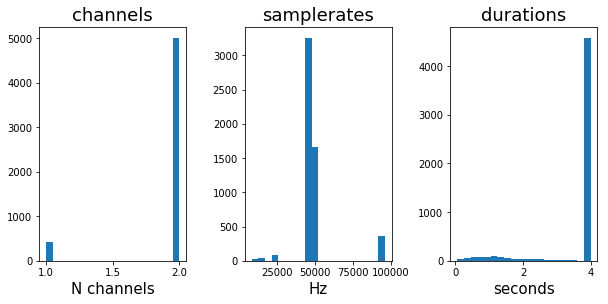

In [138]:
#plot the characteristics of the sounds in the dataset
stats = [channels, samplerates, durations]
labels = ['channels', 'samplerates', 'durations']
xlabels = ['N channels', 'Hz', 'seconds']
fig = plt.figure(figsize=(10,10))
k = -1
for stat in stats:
    k = k+1
    plt.subplot(1,3,k+1)
    plt.hist(stat,20)
    plt.title(labels[k], fontsize = 18)
    plt.xlabel(xlabels[k], fontsize = 15)
plt.subplots_adjust(top = 0.45, wspace = 0.4)
plt.show()

As we can see, there is variability in all the three sound characteristics unedr exhamination. We will make use of librosa and set some keywords arguments in the librosa.load() function in order to homogeneize the dataset. Librosa will automatically set the samplerate to 22050Hz and we will have to pass the 'mono' argument like such:

In [134]:
#example of how to load a sample with fixed nchannels
data, sr = lb.load(files[0], mono = True)
print(data.shape)
print(sr)

(88200,)
22050


Another problem is that the lengths of the audio files are not the same. The majority of samples is 4s long but there are quite a few that are shorter. To resolve this, we are going to pad the short samples with zeros before passing them to the model.

## Dataset labels distribution
Next, let's check wheter we have a similar number of audio examples for each of the classes we want to classifiy. To do that we first load the train.csv file as a pandas dataframe, then we look at the number of different counts for each label.

In [95]:
infos = pd.read_csv(os.path.join(path, "train.csv"))

In [96]:
infos[:10]

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark
5,6,children_playing
6,10,street_music
7,11,drilling
8,12,gun_shot
9,15,dog_bark


different sound categories : 
air_conditioner, engine_idling, gun_shot, jackhammer, street_music, drilling, children_playing, dog_bark, siren, car_horn


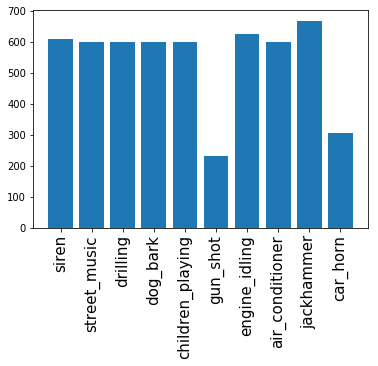

In [129]:
from collections import Counter

labels = ', '.join(list(set(infos['Class'])))
print(f'different sound categories : \n{labels}')

count_dict = Counter(infos['Class'])
Ns = []
for key, values in count_dict.items():
    Ns.append(values)
plt.bar(range(len(count_dict.keys())), Ns,)
plt.xticks(range(len(count_dict.keys())),  count_dict.keys(), rotation='vertical', fontsize = 15)

plt.show()

The dataset is fairly homogeneus but it has less gun shots and car horns. (I can understand it might hopefully be difficult to record gun shots in an urban environment but why such few ca horns??)

# Dataset and Dataloaders for pytorch
### The Dataset class

In [208]:
from torch.utils.data import Dataset, DataLoader
import os
import glob

class UrbanSoundDataset(Dataset):
    
    def __init__(self, datapath, transforms, train_or_test, sample_len=4*22050):
        self.sample_len = sample_len
        self.path = datapath
        self.files = [y for x in os.walk(self.path) for y in glob.glob(os.path.join(x[0], '*.wav'))]
        self.len = len(files)
        self.transforms = transforms
        if train_or_test == 'train':
            self.infos = pd.read_csv(os.path.join(self.path, 'train.csv'))
        elif train_or_test == 'test':
            self.infos = pd.read_csv(os.path.join(self.path, 'train.csv'))
        else:
            print('WARNING: the train_or_test argument should be a string <train> or <test> ')
            1/0
        
        self.classes = sorted(set(infos.Class))
        
    def __getitem__(self, index):
        sample, sr = lb.load(files[index], mono = True)
        if len(sample) < self.sample_len:
            sample = np.insert(sample, 0, np.zeros(self.sample_len - len(sample)))
        label_str = self.infos.iloc[index].Class
        label = [1 if l == label_str else 0 for l in self.classes]
        label = torch.FloatTensor(label)
        if self.transforms:
            sample = self.transforms(sample)
        return (sample, label)
             
    def __len__(self):
        return self.len

In [209]:
train_dataset = UrbanSoundDataset(trainpath, None, 'train')

In [210]:
train_loader = DataLoader(train_dataset, 10, shuffle = True)
next(iter(train_loader))

[tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0737,  0.0737,  0.0000],
         [-0.0006, -0.0098, -0.0348,  ...,  0.2316,  0.2393,  0.2899],
         [-0.0049, -0.0037, -0.0007,  ...,  0.0271,  0.0015, -0.0113],
         ...,
         [-0.1020, -0.1543, -0.0709,  ..., -0.0870, -0.0559, -0.0230],
         [-0.0312, -0.0544, -0.0591,  ...,  0.0565,  0.0227, -0.0259],
         [ 0.0075,  0.0106,  0.0105,  ...,  0.0276,  0.0195,  0.0071]]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]

# Simple 1D conv approach 

In [212]:
class Classifier1D(nn.Module):
    def __init__(self):
        super(Classifier1D, self).__init__()
        self.conv1 = nn.Conv

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [161]:
ls

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

In [158]:
sorted(ls)

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

In [159]:
ls

['air_conditioner',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'street_music',
 'drilling',
 'children_playing',
 'dog_bark',
 'siren',
 'car_horn']